# Disaster Tweets Prediction

The goal of this project is to predict if a tweet pertains to a disaster or not. The disaster has to be real and not someone saying something like "My dining experience was a disaster!" The dataset consists of tweets, which have been labeled 1 if they are about a disaster or 0 otherwise. There may also be a keyword and/or location for each tweet. The kaggle competition is judged using F1 score so I will be using that as my main metric.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_hub as hub
import tensorflow_text
# import tensorflow_addons as tfa

import kaggle

In [2]:
data = pd.read_csv('train.csv', keep_default_na=False)
to_predict = pd.read_csv('test.csv', keep_default_na=False)

print(f"Dataset shape = {data.shape}")
data.head(10)

Dataset shape = (7613, 5)


,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1
5,8,,,#RockyFire Update => California Hwy. 20 closed...,1
6,10,,,#flood #disaster Heavy rain causes flash flood...,1
7,13,,,I'm on top of the hill and I can see a fire in...,1
8,14,,,There's an emergency evacuation happening now ...,1
9,15,,,I'm afraid that the tornado is coming to our a...,1


## EDA

Let's take a look at the dataset

In [3]:
print(f"Empty keywords: {data.keyword[data.keyword == ''].count()}")
print(f"Empty locations: {data.location[data.location == ''].count()}")

Empty keywords: 61
Empty locations: 2533


The dataset consists of 7613 tweets. There are 61 empty keywords and 2533 empty location values. Since there are a lot of missing values and they are not that important I am just going to disregard them from now on and only use the tweet text. 

Let's look at class distributions

<AxesSubplot:xlabel='target', ylabel='count'>

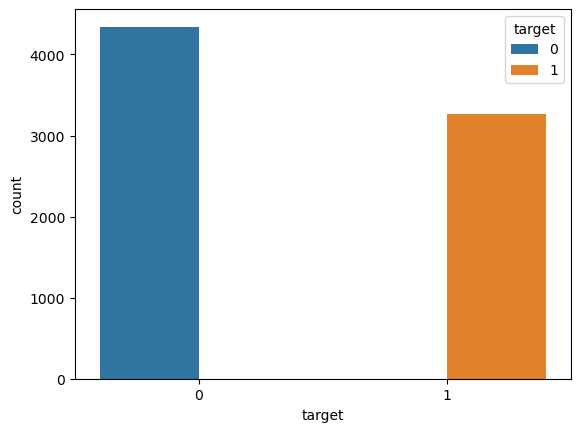

In [4]:
sns.countplot(x=data['target'], hue=data['target'])

The classes are approximately balanced.

Let's make some word clouds split by whether there was a disaster or not.

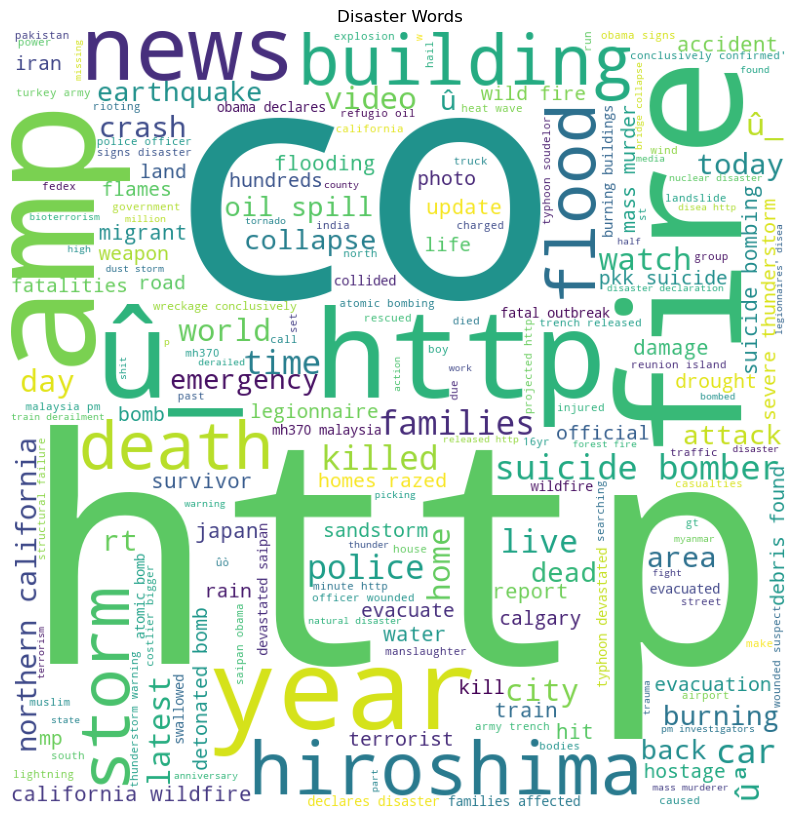

In [5]:
comment_words = ''
# stopwords = set(STOPWORDS)
 
# iterate through the csv file
for idx, row in data[data.target == 1].iterrows():
    tokens = row['text'].split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens) + " "
 
wordcloud_disaster = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words(),
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_disaster)
plt.title("Disaster Words")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

"people", "building", "hiroshima" & "fire" and many other disaster-related works make appearances. "https" is from when users post links, and "co" is from "t.co" which is how Twitter hosts images and we didn't filter them out beforehand so they also make appearances. 

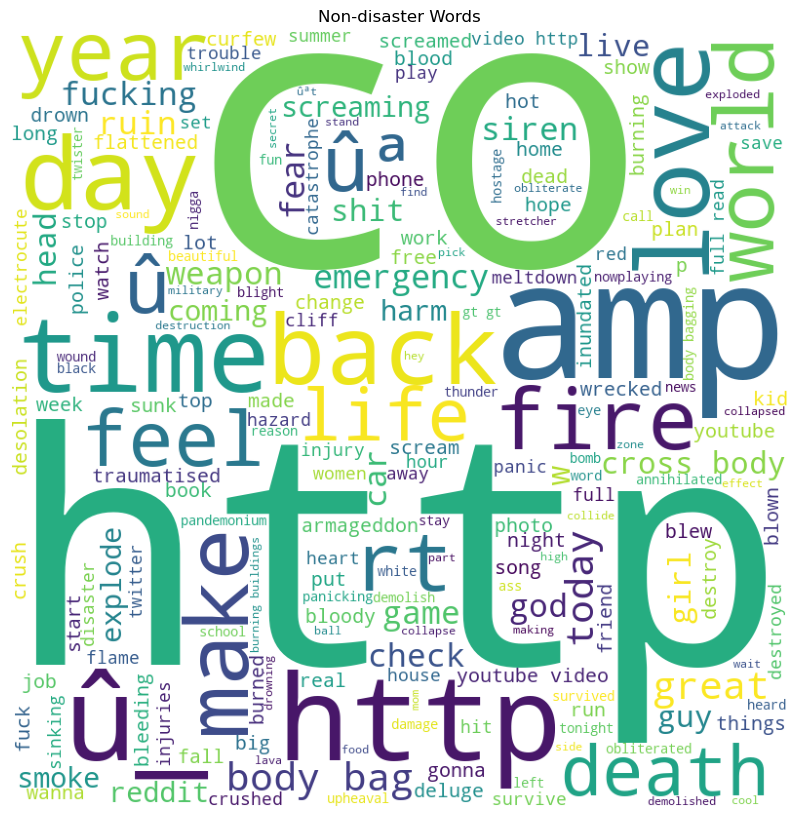

In [6]:
comment_words = ''
 
# iterate through the csv file
for idx, row in data[data.target == 0].iterrows():
    tokens = row['text'].split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens) + " "
 
wordcloud_no_disaster = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words(),
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_no_disaster)
plt.title("Non-disaster Words")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

"https" and "co" make appearances again, since we didn't filter them out beforehand, but there's no real theme to this wordclound since these are essentially random tweets. 

Based on this EDA, let's clean the tweets and remove things like "http".

In [29]:
def clean_text(tweet):
    # remove url
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    # remove punctuation
    tweet = re.sub(r"it's", 'it is', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"i'm", 'i am', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"i've", 'i have', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"we've", 'we have', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"can't", 'cannot', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"won't", 'will not', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"isn't", 'is not', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"you're", 'you are', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r" u ", ' you ', tweet, flags=re.IGNORECASE)
    tweet = re.sub(r"'ll", ' will', tweet, flags=re.IGNORECASE)
    
    
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    tweet = re.sub(r'\W+',' ', tweet)

    tweet = tweet.lower()
    words = word_tokenize(tweet)
    words = [word for word in words if word.isalpha() and word not in stopwords.words()]
#     print(" ".join(words))
#     print("-------------")

    return " ".join(words)

# for tweet in data['text']:
#     clean_text(tweet)
    
# data['text_cleaned'] = data['text'].apply(lambda s : clean_text(s))
# data.to_pickle("./cleaned_df.pkl")
data = pd.read_pickle("./cleaned_df.pkl")

# to_predict['text_cleaned'] = to_predict['text'].apply(lambda s : clean_text(s))
# to_predict.to_pickle("./cleaned_predict.pkl")
to_predict = pd.read_pickle("./cleaned_predict.pkl")

# data.head()
to_predict.head()

,id,keyword,location,text,text_cleaned
0,0,,,Just happened a terrible car crash,happened terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe
2,3,,,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing street save
3,9,,,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


## Build Model

Split into train/test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data['text_cleaned'],data['target'], stratify=data['target'])
X_train.head()

5961                                tyleroakley screaming
913     chxrmingprince bloody hope folding arms sittin...
381     spokane authorities struggling solve arson cas...
7354        oregon biggest wildfire slows growth katunews
5829                                 found diamond rubble
Name: text_cleaned, dtype: object

Let's use BERT to encode the processed tweets as vectors. BERT takes a sentence and returns a vector of length 768, which is a dimensionality-reduced vector representation of the words in the sentence. 

Import BERT preprocessor and encoder

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

## Model Architecture

Using BERT to encode the cleaned data involved feeding the text input into the proprocessor, and then that into the encoder. After that, the model is really simple with the 768 BERT neurons given dropout to prevent overfitting and then they all connect to a single dense output neuron with sigmoid activation. 

In [68]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [69]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

optimizer = Adam()
# optimizer = SGD(learning_rate=0.001, momentum=0.8)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

In [70]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
179/179 [==============================] - 25s 129ms/step - loss: 0.6645 - accuracy: 0.6066 - precision: 0.5587 - recall: 0.4015
Epoch 2/15
179/179 [==============================] - 23s 127ms/step - loss: 0.6071 - accuracy: 0.6784 - precision: 0.6623 - recall: 0.5132
Epoch 3/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5781 - accuracy: 0.7152 - precision: 0.7062 - recall: 0.5773
Epoch 4/15
179/179 [==============================] - 23s 131ms/step - loss: 0.5669 - accuracy: 0.7183 - precision: 0.7091 - recall: 0.5842
Epoch 5/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5543 - accuracy: 0.7313 - precision: 0.7238 - recall: 0.6058
Epoch 6/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5470 - accuracy: 0.7418 - precision: 0.7284 - recall: 0.6364
Epoch 7/15
179/179 [==============================] - 23s 130ms/step - loss: 0.5358 - accuracy: 0.7457 - precision: 0.7364 - recall: 0.6355
Epoch 8/15
179/179 [

In [71]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

f1_score(y_test, y_predicted) # 0.6510344827586206 for SGD, 0.6708683473389356 for Adam

60/60 [==============================] - 8s 127ms/step


0.6708683473389356

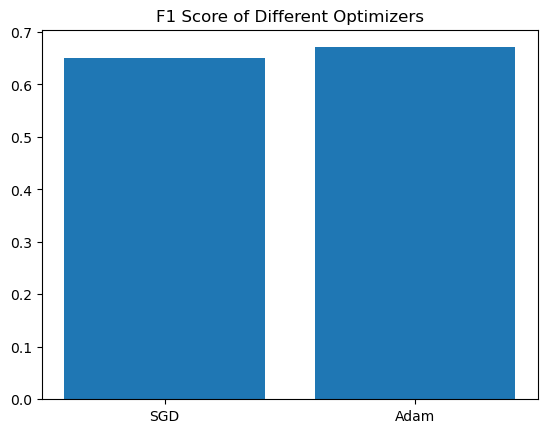

In [72]:
plt.bar(["SGD", "Adam"], [0.6510344827586206, 0.6708683473389356])
plt.title("F1 Score of Different Optimizers")
plt.show()

In [50]:
predictions = model.predict(to_predict['text_cleaned'])
predictions

102/102 [==============================] - 13s 127ms/step


array([[0.46494406],
       [0.7369659 ],
       [0.7826129 ],
       ...,
       [0.8650854 ],
       [0.54570836],
       [0.7064529 ]], dtype=float32)

In [51]:
submissions = to_predict[['id']].copy()
submissions['target'] = predictions
submissions['target'] = submissions['target'].apply(lambda x: 1 if x>0.5 else 0)
submissions.to_csv('disaster03.csv', index=False) 

## Alternate Architecture

Let's see what happens when we add a dense hidden layer of 10 neurons (with dropout).

In [74]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(10, activation='sigmoid', name="hidden")(l)
l = tf.keras.layers.Dropout(0.2, name="dropout_hidden")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model2 = tf.keras.Model(inputs=[text_input], outputs = [l])

model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [75]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

optimizer = Adam()
# optimizer = SGD(learning_rate=0.001, momentum=0.8)

model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

In [76]:
model2.fit(X_train, y_train, epochs=15)

Epoch 1/15
179/179 [==============================] - 24s 126ms/step - loss: 0.6625 - accuracy: 0.6022 - precision: 0.5746 - recall: 0.2858
Epoch 2/15
179/179 [==============================] - 23s 128ms/step - loss: 0.6107 - accuracy: 0.6833 - precision: 0.6850 - recall: 0.4868
Epoch 3/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5827 - accuracy: 0.7063 - precision: 0.6915 - recall: 0.5711
Epoch 4/15
179/179 [==============================] - 23s 129ms/step - loss: 0.5643 - accuracy: 0.7213 - precision: 0.7125 - recall: 0.5891
Epoch 5/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5567 - accuracy: 0.7294 - precision: 0.7221 - recall: 0.6017
Epoch 6/15
179/179 [==============================] - 23s 128ms/step - loss: 0.5464 - accuracy: 0.7360 - precision: 0.7285 - recall: 0.6148
Epoch 7/15
179/179 [==============================] - 23s 130ms/step - loss: 0.5412 - accuracy: 0.7416 - precision: 0.7358 - recall: 0.6221
Epoch 8/15
179/179 [

In [77]:
y_predicted = model2.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

f1_score(y_test, y_predicted)

60/60 [==============================] - 8s 126ms/step


0.6186374314800313

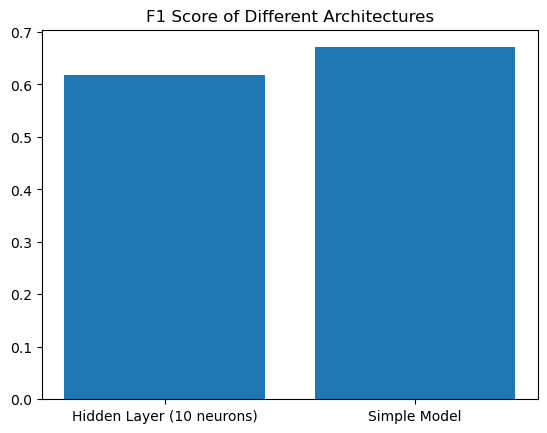

In [79]:
plt.bar(["Hidden Layer (10 neurons)", "Simple Model"], [0.6186374314800313, 0.6708683473389356])
plt.title("F1 Score of Different Architectures")
plt.show()

In [52]:
!kaggle competitions submit -c nlp-getting-started -f "disaster03.csv" -m "BERT Attempt 2"

Successfully submitted to Natural Language Processing with Disaster Tweets



  0%|          | 0.00/25.4k [00:00<?, ?B/s]
 31%|###1      | 8.00k/25.4k [00:00<00:00, 68.9kB/s]
100%|##########| 25.4k/25.4k [00:01<00:00, 13.5kB/s]


# Conclusion
- Tweets were cleaned of punctuation and stopwords were removed
- A simple model with BERT encodings resulted in an F1 score of 0.77015
- Changing the dropout threshold didn't have much of an effect on F1 score
- SGD and Adam optimizers were about the same for F1 score
- Adding a 10 neuron hidden layer resulted in a slightly worse F1 score, probably because it's adding unnecessary complexity
- Changing the model architecture probably isn't going to change the final score as much as better cleaning of the data. E.g. tweets are limited to 280 characters and people use abbreviations. I'm guessing abbreviations and hashtags appear as nonsense to the BERT encoder and may or may not end up being similarily represented as their full form


# References

https://colab.research.google.com/drive/1ZY9IQZ_ZeqjbBEDKWHgcldaY_zRZrh2R?usp=sharing#scrollTo=v-TclwGUgTcM
https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb